In [105]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tardis_dev import datasets, get_exchange_details

import nest_asyncio
nest_asyncio.apply()

# exchange data info
# https://api.tardis.dev/v1/exchanges/binance

In [53]:
class TardisLoader:
    def __init__(self, root_dir: str, api_key: str):
        self._root_dir = root_dir
        self._api_key = api_key

    def load(self, start, end, data_type, exchange, symbol):
        datasets.download(
            exchange=exchange,
            data_types=[data_type],
            from_date=str(start),
            to_date=str(end),
            symbols=[symbol],
            download_dir=f"{self._root_dir}/{data_type}-{exchange}_{symbol}",
            api_key=self._api_key
        )
        
        def path(date: str, data_type: str, exchange: str, symbol: str) -> str:
            return \
                f"{self._root_dir}/{data_type}-{exchange}_{symbol}" \
                f"/{exchange}_{data_type}_{date}_{symbol}.csv.gz"

        df = pd.concat([
            pd.read_csv(path(str(d.date()), data_type, exchange, symbol))
            for d in pd.date_range(start, end)
        ]).reset_index(drop=True)
        df.index = pd.to_datetime(df["timestamp"], unit="us", utc=True)

        return df.sort_index()

In [47]:
root_dir = './Data'
api_key = 'TD.sSGNjEpohBl9i0FV.zz0-s-b6DZ9c2lt.uoNpgBPGaTITrA9.YlW26JKS0PSfoOG.2pEnnkHAnTpOloD.3wMo'

Tardis_data = TardisLoader(root_dir, api_key)

### Load data

In [193]:
start_time = datetime.strptime("2024-06-02", "%Y-%m-%d")
end_time = datetime.strptime("2024-06-03", "%Y-%m-%d")

# Load the trades data
btc_trade_binance = Tardis_data.load(start_time, end_time, data_type='trades', exchange='binance', symbol='btcusdt')
btc_trade_bybit = Tardis_data.load(start_time, end_time, data_type='trades', exchange='bybit-spot', symbol='btcusdt')
btc_trade_okex = Tardis_data.load(start_time, end_time, data_type='trades', exchange='okex', symbol='BTC-USDT')
btc_trade_kucoin = Tardis_data.load(start_time, end_time, data_type='trades', exchange='kucoin', symbol='BTC-USDT')


# Load the quotes data (BBO)
btc_quote_binance = Tardis_data.load(start_time, end_time, data_type='quotes', exchange='binance', symbol='btcusdt')
btc_quote_bybit = Tardis_data.load(start_time, end_time, data_type='quotes', exchange='bybit-spot', symbol='btcusdt')
btc_quote_okex = Tardis_data.load(start_time, end_time, data_type='quotes', exchange='okex', symbol='BTC-USDT')
btc_quote_kucoin = Tardis_data.load(start_time, end_time, data_type='quotes', exchange='kucoin', symbol='BTC-USDT')

In [266]:
def drop_duplicate_rows(df):
    # Identify rows where the bid and ask prices change
    condition = (df['bid_price'] != df['bid_price'].shift(-1)) | (df['ask_price'] != df['ask_price'].shift(-1))
    
    # Filter the dataframe to keep only these rows
    unique_df = df[condition].reset_index(drop=True)
    
    return unique_df

In [268]:
# Drop duplicate rows
bybit_unique_df = drop_duplicate_rows(btc_quote_bybit.sort_values(by='local_timestamp', ascending=False))

binance_unique_df = drop_duplicate_rows(btc_quote_binance.sort_values(by='local_timestamp', ascending=False))

In [276]:
bybit_unique_df

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
0,bybit-spot,BTCUSDT,1717459198821000,1717459198857596,0.623302,68807.92,68807.91,0.000581
1,bybit-spot,BTCUSDT,1717459198802000,1717459198838273,0.078344,68808.57,68808.56,0.006970
2,bybit-spot,BTCUSDT,1717459187061000,1717459187098113,0.000409,68808.60,68808.59,0.096758
3,bybit-spot,BTCUSDT,1717459187042000,1717459187078528,0.000600,68806.60,68806.26,0.289738
4,bybit-spot,BTCUSDT,1717459174241000,1717459174277504,0.201252,68806.27,68806.26,0.000068
...,...,...,...,...,...,...,...,...
207859,bybit-spot,BTCUSDT,1717286406802000,1717286406839757,0.059000,67753.50,67753.49,0.210593
207860,bybit-spot,BTCUSDT,1717286405802000,1717286405839864,0.000026,67751.11,67751.10,0.169043
207861,bybit-spot,BTCUSDT,1717286405621000,1717286405659570,0.110332,67749.73,67749.72,0.454625
207862,bybit-spot,BTCUSDT,1717286405601000,1717286405639225,0.140000,67761.93,67761.92,0.001271


In [278]:
binance_unique_df

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount
0,binance,BTCUSDT,1717459174190000,1717459174195273,10.33396,68809.90,68809.89,0.00975
1,binance,BTCUSDT,1717459152279000,1717459152282091,8.40592,68812.59,68812.58,0.71376
2,binance,BTCUSDT,1717459152179000,1717459152184037,0.44485,68816.90,68814.61,0.00014
3,binance,BTCUSDT,1717458990396000,1717458990400919,10.25336,68821.49,68821.48,0.29736
4,binance,BTCUSDT,1717458984593000,1717458984597682,2.90637,68822.19,68822.18,7.14361
...,...,...,...,...,...,...,...,...
44055,binance,BTCUSDT,1717286413262000,1717286413265396,0.04000,67763.50,67763.49,8.78016
44056,binance,BTCUSDT,1717286412361000,1717286412365150,0.61183,67761.20,67761.19,8.92627
44057,binance,BTCUSDT,1717286412261000,1717286412264857,0.16298,67760.19,67760.18,6.69736
44058,binance,BTCUSDT,1717286405658000,1717286405662373,7.31082,67759.00,67758.99,0.09918


In [290]:
combined_df = pd.concat([bybit_unique_df, binance_unique_df]).sort_values(by='timestamp').reset_index(drop=True)

# Create new columns for the most recent binance-spot ask_price and bid_price
combined_df['most_recent_binance_ask_price'] = combined_df[::-1].apply(
    lambda row: row['ask_price'] if row['exchange'] == 'binance' else None, axis=1
).fillna(method='bfill')

combined_df['most_recent_binance_bid_price'] = combined_df[::-1].apply(
    lambda row: row['bid_price'] if row['exchange'] == 'binance' else None, axis=1
).fillna(method='bfill')

/var/folders/wv/rmqjztb105qfp_8c1kg92t6h0000gn/T/ipykernel_12911/3494325691.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='bfill')
/var/folders/wv/rmqjztb105qfp_8c1kg92t6h0000gn/T/ipykernel_12911/3494325691.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ).fillna(method='bfill')


In [307]:
final_df = combined_df[combined_df['exchange'] != 'binance'].dropna()

In [309]:
final_df['bid_diff'] = final_df['bid_price'] - final_df['most_recent_binance_bid_price']
final_df['ask_diff'] = final_df['ask_price'] - final_df['most_recent_binance_ask_price']

In [319]:
final_df['ask_diff'].mean()

1.867900059173928

In [317]:
final_df['bid_diff'].mean()

1.4616598432616892

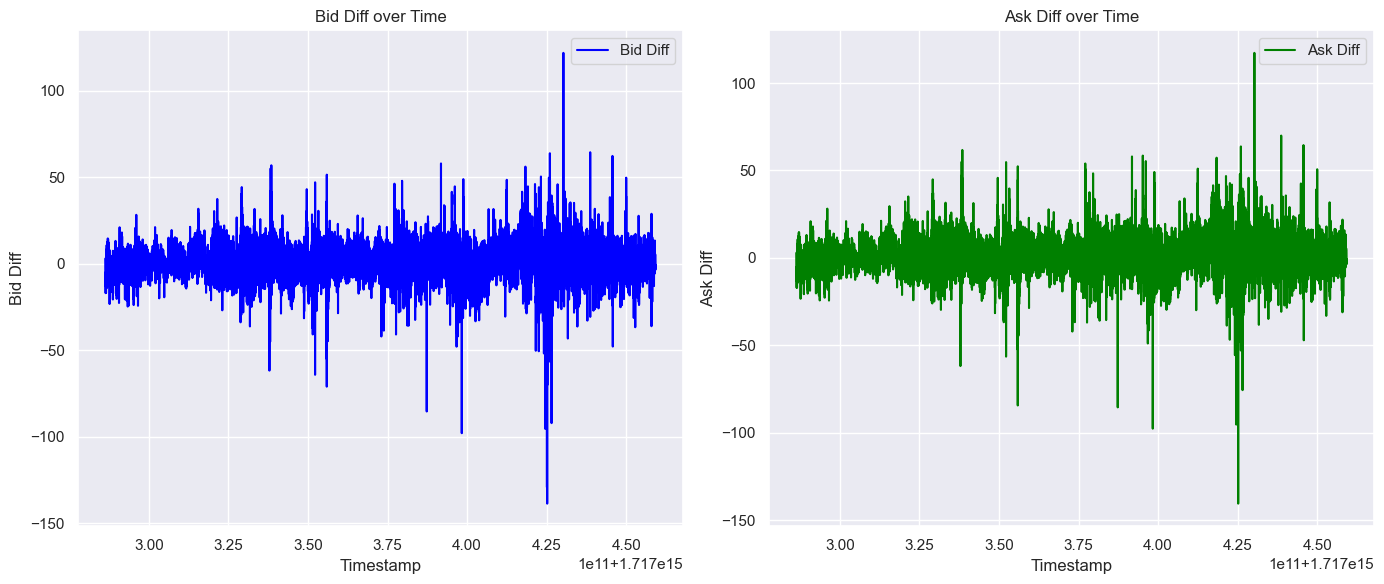

In [313]:
# Create a figure with two subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Ask Price
ax[0].plot(final_df['timestamp'], final_df['bid_diff'], label='Bid Diff', color='blue')
ax[0].set_xlabel('Timestamp')
ax[0].set_ylabel('Bid Diff')
ax[0].set_title('Bid Diff over Time')
ax[0].legend()
ax[0].grid(True)

# Plotting Bid Price
ax[1].plot(final_df['timestamp'], final_df['ask_diff'], label='Ask Diff', color='green')
ax[1].set_xlabel('Timestamp')
ax[1].set_ylabel('Ask Diff')
ax[1].set_title('Ask Diff over Time')
ax[1].legend()
ax[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

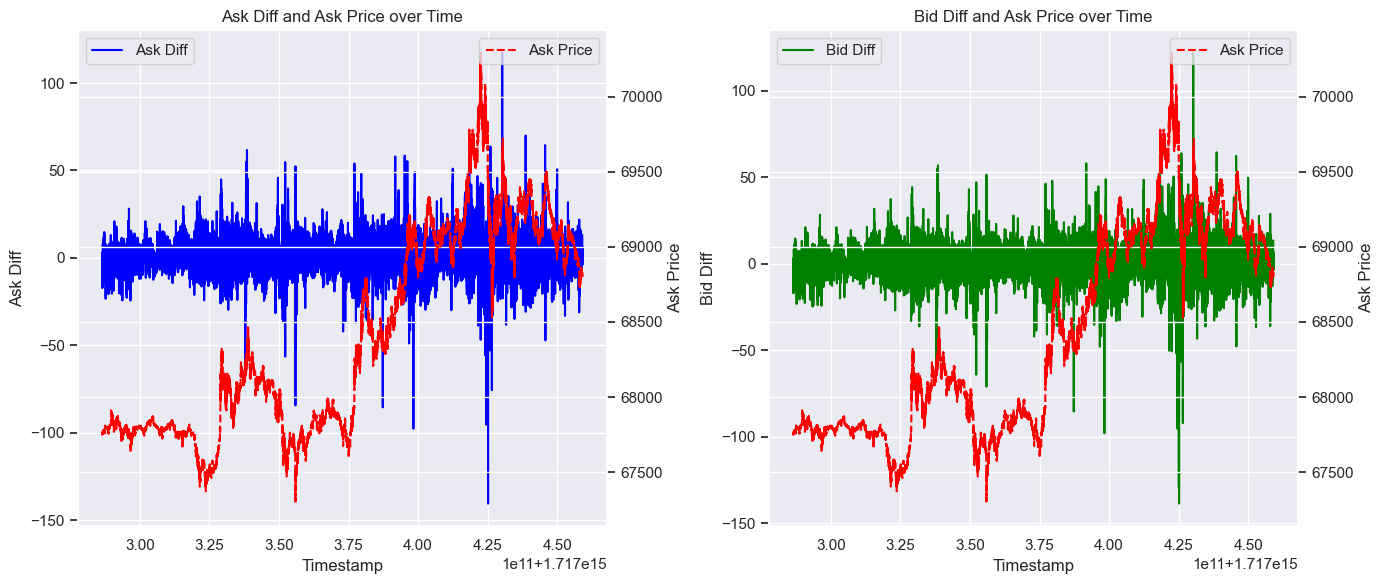

In [315]:
import matplotlib.pyplot as plt

# Create a figure with two subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plotting Ask Diff with secondary y-axis for Ask Price
ax1 = ax[0]
ax2 = ax1.twinx()
ax1.plot(final_df['timestamp'], final_df['ask_diff'], label='Ask Diff', color='blue')
ax2.plot(final_df['timestamp'], final_df['ask_price'], label='Ask Price', color='red', linestyle='--')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Ask Diff')
ax2.set_ylabel('Ask Price')
ax1.set_title('Ask Diff and Ask Price over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid(True)

# Plotting Bid Diff with secondary y-axis for Ask Price
ax3 = ax[1]
ax4 = ax3.twinx()
ax3.plot(final_df['timestamp'], final_df['bid_diff'], label='Bid Diff', color='green')
ax4.plot(final_df['timestamp'], final_df['ask_price'], label='Ask Price', color='red', linestyle='--')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Bid Diff')
ax4.set_ylabel('Ask Price')
ax3.set_title('Bid Diff and Ask Price over Time')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')
ax3.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()